In [39]:
from comet_ml import Experiment
from comet_ml import API
import os
from dotenv import load_dotenv
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibrationDisplay

warnings.filterwarnings("ignore")
load_dotenv('../.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
COMET_PROJECT_NAME = os.getenv('COMET_PROJECT_NAME')
COMET_WORKSPACE = os.getenv('COMET_WORKSPACE')

In [25]:
pd.set_option('display.max_columns', None)

In [26]:
def get_registered_comet_model(workspace, model, version, output_path):
    api = API()
    # Download a Registry Model
    file = api.download_registry_model({workspace}, model, version, output_path=output_path, expand=True)
    return file

# Question-1: Regular season

### 1.1. Read and preprocess data

In [27]:
data_regular = pd.read_csv('../data/testSet.csv')
data_regular = data_regular.drop(labels='index', axis=1).reset_index(drop=True)
data_regular['Goal'] = data_regular['Goal'].astype(np.int64)
display(data_regular.shape)
data_regular.head()

(68500, 39)

,eventType,period,periodTime,periodType,gameID,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,goalie,shotType,emptyNet,strength,season,rinkSide,gameType,totalPlayTime,lastEventType,lastEventPeriod,lastEventPeriodTime,lastEventXCoord,lastEventYCoord,Goal,EmptyNet,distanceFromNet,angle,gameSeconds,lastEventGameSeconds,timeFromLastEvent,distanceFromLastEvent,rebound,lastEventAngle,changeInAngleShot,speed,timeSincePowerPlayStarted,numFriendlyNonGoalieSkaters,numOpposingNonGoalieSkaters,strength2
0,Goal,1,00:25,REGULAR,2019020001,Ottawa Senators,away,85.0,-1.0,Brady Tkachuk,Frederik Andersen,Tip-In,False,Even,2019,left,R,01:00:00,Faceoff,1,00:00,0.0,0.0,1,0.0,4.123106,75.963757,25.0,0.0,25.0,85.005882,0.0,NaN,NaN,3.400235,0.0,5.0,5.0,Even
1,Shot,1,01:31,REGULAR,2019020001,Toronto Maple Leafs,home,-32.0,-2.0,Morgan Rielly,Craig Anderson,Snap Shot,NaN,NaN,2019,right,R,01:00:00,Giveaway,1,01:04,-36.0,-31.0,0,0.0,57.035077,92.009554,91.0,64.0,27.0,29.274562,0.0,NaN,NaN,1.084243,35.0,5.0,4.0,Power Play
2,Shot,1,03:23,REGULAR,2019020001,Ottawa Senators,away,63.0,-6.0,Dylan DeMelo,Frederik Andersen,Snap Shot,NaN,NaN,2019,left,R,01:00:00,Missed Shot,1,03:09,-64.0,-4.0,0,0.0,26.683328,77.005383,203.0,189.0,14.0,127.015747,0.0,NaN,NaN,9.072553,0.0,5.0,5.0,Even
3,Shot,1,03:56,REGULAR,2019020001,Toronto Maple Leafs,home,-59.0,-20.0,Morgan Rielly,Craig Anderson,Wrist Shot,NaN,NaN,2019,right,R,01:00:00,Takeaway,1,03:50,34.0,-20.0,0,0.0,36.055513,123.690068,236.0,230.0,6.0,93.000000,0.0,NaN,NaN,15.500000,0.0,5.0,5.0,Even
4,Shot,1,04:47,REGULAR,2019020001,Toronto Maple Leafs,home,-42.0,-29.0,Tyson Barrie,Craig Anderson,Slap Shot,NaN,NaN,2019,right,R,01:00:00,Missed Shot,1,04:41,-86.0,4.0,0,0.0,55.226805,121.675469,287.0,281.0,6.0,55.000000,0.0,NaN,NaN,9.166667,0.0,5.0,5.0,Even


In [28]:
# Read and preprocess data
df3_regular = data_regular[['distanceFromNet', 'angle', 'EmptyNet', 'Goal']]
df3_regular = df3_regular.rename({'Goal': 'is_goal', 'distanceFromNet': 'distance'}, axis=1)
df3_regular = df3_regular.dropna().reset_index(drop=True)
display(df3_regular.shape)
df3_regular.head()

(68499, 4)

,distance,angle,EmptyNet,is_goal
0,4.123106,75.963757,0.0,1
1,57.035077,92.009554,0.0,0
2,26.683328,77.005383,0.0,0
3,36.055513,123.690068,0.0,0
4,55.226805,121.675469,0.0,0


### 1.2. Load registered models

In [29]:
Xr1 = df3_regular['distance'].to_numpy().reshape(-1, 1)
yr = df3_regular['is_goal'].to_numpy().reshape(-1, 1)

filename = '../tmp/3-lr_distance.joblib'
get_registered_comet_model(COMET_WORKSPACE, 'lr-distance-model', '1.0.0', '../tmp/')
lr_distance = load(filename)

preds1 = lr_distance.predict(Xr1)

COMET INFO: Downloading registry model 'lr-distance-model', version '1.0.0', stage None from workspace {'meriembchaaben'}...
COMET INFO: Unzipping model to 'C:\\Users\\oussa\\OneDrive\\Desktop\\UdeM\\PhD\\Courses\\Fall-21\\IFT-6758-DataScience\\Project\\milestone-2\\IFT6758-code\\IFT6758\\tmp' ...
COMET INFO: done!


In [30]:
Xr2 = df3_regular['angle'].to_numpy().reshape(-1, 1)

filename = '../tmp/3-lr_angle.joblib'
get_registered_comet_model(COMET_WORKSPACE, 'lr-angle-model', '1.0.0', '../tmp/')
lr_angle = load(filename)

preds2 = lr_angle.predict(Xr2)

COMET INFO: Downloading registry model 'lr-angle-model', version '1.0.0', stage None from workspace {'meriembchaaben'}...
COMET INFO: Unzipping model to 'C:\\Users\\oussa\\OneDrive\\Desktop\\UdeM\\PhD\\Courses\\Fall-21\\IFT-6758-DataScience\\Project\\milestone-2\\IFT6758-code\\IFT6758\\tmp' ...
COMET INFO: done!


In [31]:
Xr3 = df3_regular[['distance', 'angle']].to_numpy().reshape(-1, 2)

filename = '../tmp/3-lr_distance_angle.joblib'
get_registered_comet_model(COMET_WORKSPACE, 'lr-distance-angle-model', '1.0.0', '../tmp/')
lr_distance_angle = load(filename)

preds3 = lr_distance_angle.predict(Xr3)

COMET INFO: Downloading registry model 'lr-distance-angle-model', version '1.0.0', stage None from workspace {'meriembchaaben'}...
COMET INFO: Unzipping model to 'C:\\Users\\oussa\\OneDrive\\Desktop\\UdeM\\PhD\\Courses\\Fall-21\\IFT-6758-DataScience\\Project\\milestone-2\\IFT6758-code\\IFT6758\\tmp' ...
COMET INFO: done!


### 1.3. Evaluate models

In [32]:
print('####### Logistic Regression (distance) #######')
target_names = ['Non-goal', 'Goal']
accuracy1 = lr_distance.score(Xr1, yr)
brier1 = brier_score_loss(yr, preds1)
print(f'Test accuracy: {accuracy1}' )
print(f'Brier score: {brier1}' )
print('** Classification report **')
print(classification_report(yr, preds1, target_names=target_names))

####### Logistic Regression (distance) #######
Test accuracy: 0.9029474882845006
Brier score: 0.0970525117154995
** Classification report **
              precision    recall  f1-score   support

    Non-goal       0.90      1.00      0.95     61851
        Goal       0.00      0.00      0.00      6648

    accuracy                           0.90     68499
   macro avg       0.45      0.50      0.47     68499
weighted avg       0.82      0.90      0.86     68499



In [33]:
print('####### Logistic Regression (angle) #######')
target_names = ['Non-goal', 'Goal']
accuracy2 = lr_angle.score(Xr2, yr)
brier2 = brier_score_loss(yr, preds2)
print(f'Test accuracy: {accuracy2}' )
print(f'Brier score: {brier2}' )
print('** Classification report **')
print(classification_report(yr, preds2, target_names=target_names))

####### Logistic Regression (angle) #######
Test accuracy: 0.9029474882845006
Brier score: 0.0970525117154995
** Classification report **
              precision    recall  f1-score   support

    Non-goal       0.90      1.00      0.95     61851
        Goal       0.00      0.00      0.00      6648

    accuracy                           0.90     68499
   macro avg       0.45      0.50      0.47     68499
weighted avg       0.82      0.90      0.86     68499



In [34]:
print('####### Logistic Regression (distance+angle) #######')
target_names = ['Non-goal', 'Goal']
accuracy3 = lr_distance_angle.score(Xr3, yr)
brier3 = brier_score_loss(yr, preds3)
print(f'Test accuracy: {accuracy3}' )
print(f'Brier score: {brier3}' )
print('** Classification report **')
print(classification_report(yr, preds3, target_names=target_names))

####### Logistic Regression (distance+angle) #######
Test accuracy: 0.9029474882845006
Brier score: 0.0970525117154995
** Classification report **
              precision    recall  f1-score   support

    Non-goal       0.90      1.00      0.95     61851
        Goal       0.00      0.00      0.00      6648

    accuracy                           0.90     68499
   macro avg       0.45      0.50      0.47     68499
weighted avg       0.82      0.90      0.86     68499



### 1.2. Visualization

Logistic Regression (trained on distance only): ROC AUC=0.704
Logistic Regression (trained on angle only): ROC AUC=0.508
Logistic Regression (trained on both distance and angle): ROC AUC=0.704
Random: ROC AUC=0.500


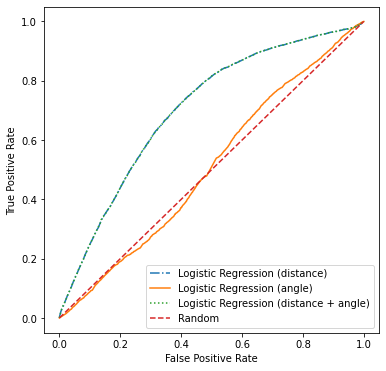

In [35]:
### ROC curve - AUC metric ###

lr_probs1 = lr_distance.predict_proba(Xr1[:, :])[:,1]
lr_probs2 = lr_angle.predict_proba(Xr2[:, :])[:,1]
lr_probs3 = lr_distance_angle.predict_proba(Xr3[:, :])[:,1]

random_clf = DummyClassifier(strategy="uniform").fit(Xr1, yr)
random_probs = random_clf.predict_proba(Xr1[:, :])[:,1]



lr_auc1 = roc_auc_score(yr, lr_probs1)
lr_auc2 = roc_auc_score(yr, lr_probs2)
lr_auc3 = roc_auc_score(yr, lr_probs3)
random_auc = roc_auc_score(yr, random_probs)


print('Logistic Regression (trained on distance only): ROC AUC=%.3f' % (lr_auc1))
print('Logistic Regression (trained on angle only): ROC AUC=%.3f' % (lr_auc2))
print('Logistic Regression (trained on both distance and angle): ROC AUC=%.3f' % (lr_auc3))
print('Random: ROC AUC=%.3f' % (random_auc))

lr_fpr1, lr_tpr1, _ = roc_curve(yr, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(yr, lr_probs2)
lr_fpr3, lr_tpr3, _ = roc_curve(yr, lr_probs3)
random_fpr, random_tpr, _ = roc_curve(yr, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(lr_fpr1, lr_tpr1, linestyle='-.', label='Logistic Regression (distance)')
plt.plot(lr_fpr2, lr_tpr2, linestyle='-', label='Logistic Regression (angle)')
plt.plot(lr_fpr3, lr_tpr3, linestyle=':', label='Logistic Regression (distance + angle)')
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('../figures/7-roc.png')

plt.show()

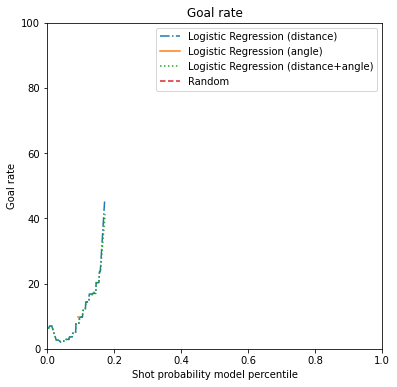

In [36]:
### goal_rate = F(shot probability model percentile) ###
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        r_percentile = round(percentile, 2)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
#             if p<=percentile:
            if round(p, 2)==r_percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals *100 / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates


percentiles1, rates1 = compute_goal_rate_per_percentile(lr_probs1, yr)
percentiles2, rates2 = compute_goal_rate_per_percentile(lr_probs2, yr)
percentiles3, rates3 = compute_goal_rate_per_percentile(lr_probs3, yr)
percentiles4, rates4 = compute_goal_rate_per_percentile(random_probs, yr)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, linestyle='-.', label='Logistic Regression (distance)')
plt.plot(percentiles2, rates2, linestyle='-', label='Logistic Regression (angle)')
plt.plot(percentiles3, rates3, linestyle=':', label='Logistic Regression (distance+angle)')
plt.plot(percentiles4, rates4, linestyle='--', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Goal rate')

plt.savefig('../figures/3-goal_rate_percentile_1.png')

plt.show()

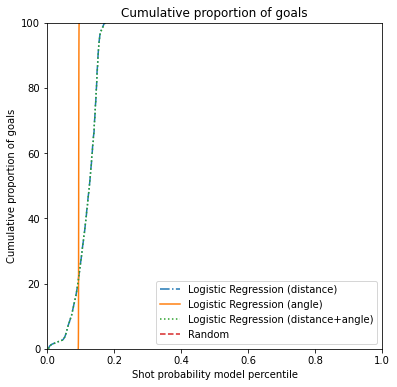

In [37]:
### cumulative portion of goals = F(shot probability model percentile) ###

def compute_cumulative_propotion_of_goals_per_percentile(probs, y):
    percentiles = []
    cum_rates = []
    cum_rate = 0
    total_goals = sum(y)
    cum_goals = 0
    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        cum_goals=0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    cum_goals+=1 
        cum_rate = cum_goals * 100 / total_goals
        percentiles.append(percentile)
        cum_rates.append(cum_rate)
    return percentiles, cum_rates


percentiles1, rates1 = compute_cumulative_propotion_of_goals_per_percentile(lr_probs1, yr)
percentiles2, rates2 = compute_cumulative_propotion_of_goals_per_percentile(lr_probs2, yr)
percentiles3, rates3 = compute_cumulative_propotion_of_goals_per_percentile(lr_probs3, yr)
percentiles4, rates4 = compute_cumulative_propotion_of_goals_per_percentile(random_probs, yr)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, linestyle='-.', label='Logistic Regression (distance)')
plt.plot(percentiles2, rates2, linestyle='-', label='Logistic Regression (angle)')
plt.plot(percentiles3, rates3, linestyle=':', label='Logistic Regression (distance+angle)')
plt.plot(percentiles4, rates4, linestyle='--', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative proportion of goals')
plt.legend(loc='lower right')
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Cumulative proportion of goals')

plt.savefig('../figures/3-goal_rate_percentile_2.png')

plt.show()

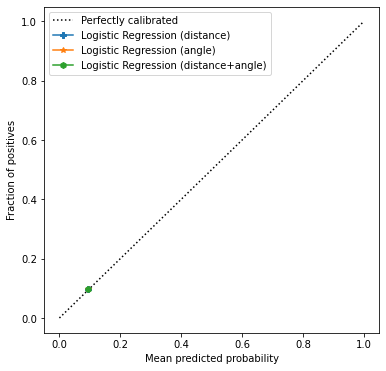

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))


disp1 = CalibrationDisplay.from_estimator(lr_distance, Xr1, yr, label='Logistic Regression (distance)', marker="P", ax=ax)
disp2 = CalibrationDisplay.from_estimator(lr_angle, Xr2, yr, label='Logistic Regression (angle)', marker="*", ax=ax)
disp3 = CalibrationDisplay.from_estimator(lr_distance_angle, Xr3, yr, label='Logistic Regression (distance+angle)', marker="h", ax=ax)

ax.legend(loc='upper left')

plt.savefig('../figures/3-calibration_diagram2.png')

plt.show()

## Question-2: Playoffs

### 1.1. Read and preprocess data

In [42]:
data_playoffs = pd.read_csv('../data/testSetPlayOff.csv')
data_playoffs = data_playoffs.drop(labels=['index', 'Unnamed: 0'], axis=1).reset_index(drop=True)
data_playoffs['Goal'] = data_playoffs['Goal'].astype(np.int64)
display(data_playoffs.shape)
data_playoffs.head()

(5367, 39)

,eventType,period,periodTime,periodType,gameID,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,goalie,shotType,emptyNet,strength,season,rinkSide,gameType,totalPlayTime,lastEventType,lastEventPeriod,lastEventPeriodTime,lastEventXCoord,lastEventYCoord,Goal,EmptyNet,distanceFromNet,angle,gameSeconds,lastEventGameSeconds,timeFromLastEvent,distanceFromLastEvent,rebound,lastEventAngle,changeInAngleShot,speed,timeSincePowerPlayStarted,numFriendlyNonGoalieSkaters,numOpposingNonGoalieSkaters,strength2
0,Shot,1,02:18,REGULAR,2019030111,Philadelphia Flyers,home,-56.0,-5.0,Sean Couturier,Carey Price,Snap Shot,NaN,NaN,2019,right,P,01:00:00,Faceoff,1,02:16,-69.0,-22.0,0,0.0,33.376639,98.615648,138.0,136.0,2.0,21.400935,0.0,NaN,NaN,10.700467,0.0,5.0,5.0,Even
1,Shot,1,04:15,REGULAR,2019030111,Montréal Canadiens,away,54.0,-26.0,Joel Armia,Carter Hart,Wrist Shot,NaN,NaN,2019,left,P,01:00:00,Missed Shot,1,03:36,-43.0,-13.0,0,0.0,43.600459,53.392925,255.0,216.0,39.0,97.867257,0.0,NaN,NaN,2.509417,0.0,5.0,5.0,Even
2,Shot,1,04:58,REGULAR,2019030111,Philadelphia Flyers,home,-61.0,38.0,Philippe Myers,Carey Price,Wrist Shot,NaN,NaN,2019,right,P,01:00:00,Blocked Shot,1,04:53,-72.0,-6.0,0,0.0,47.201695,36.384352,298.0,293.0,5.0,45.354162,0.0,NaN,NaN,9.070832,0.0,5.0,5.0,Even
3,Shot,1,05:06,REGULAR,2019030111,Philadelphia Flyers,home,-52.0,-14.0,Ivan Provorov,Carey Price,Slap Shot,NaN,NaN,2019,right,P,01:00:00,Stoppage,1,05:06,NaN,NaN,0,0.0,39.560081,110.725559,306.0,306.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,5.0,5.0,Even
4,Shot,1,06:11,REGULAR,2019030111,Philadelphia Flyers,home,-49.0,-32.0,Travis Sanheim,Carey Price,Wrist Shot,NaN,NaN,2019,right,P,01:00:00,Takeaway,1,06:07,17.0,11.0,0,0.0,51.224994,128.659808,371.0,367.0,4.0,78.771822,0.0,NaN,NaN,19.692956,0.0,5.0,5.0,Even


In [43]:
# Read and preprocess data
df3_playoffs = data_playoffs[['distanceFromNet', 'angle', 'EmptyNet', 'Goal']]
df3_playoffs = df3_playoffs.rename({'Goal': 'is_goal', 'distanceFromNet': 'distance'}, axis=1)
df3_playoffs = df3_playoffs.dropna().reset_index(drop=True)
display(df3_playoffs.shape)
df3_playoffs.head()

(5367, 4)

,distance,angle,EmptyNet,is_goal
0,33.376639,98.615648,0.0,0
1,43.600459,53.392925,0.0,0
2,47.201695,36.384352,0.0,0
3,39.560081,110.725559,0.0,0
4,51.224994,128.659808,0.0,0


In [44]:
Xp1 = df3_playoffs['distance'].to_numpy().reshape(-1, 1)
yp = df3_playoffs['is_goal'].to_numpy().reshape(-1, 1)
preds1 = lr_distance.predict(Xp1)

In [47]:
Xp2 = df3_playoffs['angle'].to_numpy().reshape(-1, 1)
yp = df3_playoffs['is_goal'].to_numpy().reshape(-1, 1)
preds2 = lr_angle.predict(Xp2)

In [48]:
Xp3 = df3_playoffs[['distance', 'angle']].to_numpy().reshape(-1, 2)
yp = df3_playoffs['is_goal'].to_numpy().reshape(-1, 1)
preds3 = lr_distance_angle.predict(Xp3)

### 2.2. Evaluate models

In [49]:
print('####### Logistic Regression (distance) #######')
target_names = ['Non-goal', 'Goal']
accuracy1 = lr_distance.score(Xp1, yp)
brier1 = brier_score_loss(yp, preds1)
print(f'Test accuracy: {accuracy1}' )
print(f'Brier score: {brier1}' )
print('** Classification report **')
print(classification_report(yp, preds1, target_names=target_names))

####### Logistic Regression (distance) #######
Test accuracy: 0.9116825041922862
Brier score: 0.08831749580771381
** Classification report **
              precision    recall  f1-score   support

    Non-goal       0.91      1.00      0.95      4893
        Goal       0.00      0.00      0.00       474

    accuracy                           0.91      5367
   macro avg       0.46      0.50      0.48      5367
weighted avg       0.83      0.91      0.87      5367



In [50]:
print('####### Logistic Regression (angle) #######')
target_names = ['Non-goal', 'Goal']
accuracy2 = lr_angle.score(Xp2, yp)
brier2 = brier_score_loss(yp, preds2)
print(f'Test accuracy: {accuracy2}' )
print(f'Brier score: {brier2}' )
print('** Classification report **')
print(classification_report(yp, preds2, target_names=target_names))

####### Logistic Regression (angle) #######
Test accuracy: 0.9116825041922862
Brier score: 0.08831749580771381
** Classification report **
              precision    recall  f1-score   support

    Non-goal       0.91      1.00      0.95      4893
        Goal       0.00      0.00      0.00       474

    accuracy                           0.91      5367
   macro avg       0.46      0.50      0.48      5367
weighted avg       0.83      0.91      0.87      5367



In [51]:
print('####### Logistic Regression (distance+angle) #######')
target_names = ['Non-goal', 'Goal']
accuracy3 = lr_distance_angle.score(Xp3, yp)
brier3 = brier_score_loss(yp, preds3)
print(f'Test accuracy: {accuracy3}' )
print(f'Brier score: {brier3}' )
print('** Classification report **')
print(classification_report(yp, preds3, target_names=target_names))

####### Logistic Regression (distance+angle) #######
Test accuracy: 0.9116825041922862
Brier score: 0.08831749580771381
** Classification report **
              precision    recall  f1-score   support

    Non-goal       0.91      1.00      0.95      4893
        Goal       0.00      0.00      0.00       474

    accuracy                           0.91      5367
   macro avg       0.46      0.50      0.48      5367
weighted avg       0.83      0.91      0.87      5367



### 2.3. Visualization

Logistic Regression (trained on distance only): ROC AUC=0.500
Logistic Regression (trained on angle only): ROC AUC=0.516
Logistic Regression (trained on both distance and angle): ROC AUC=0.499
Random: ROC AUC=0.500


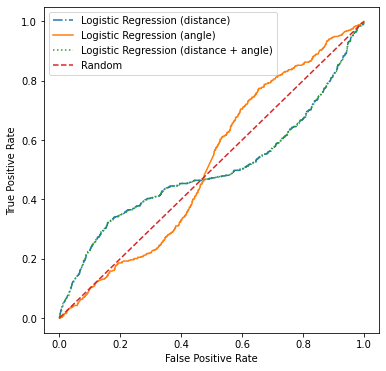

In [52]:
### ROC curve - AUC metric ###

lr_probs1 = lr_distance.predict_proba(Xp1[:, :])[:,1]
lr_probs2 = lr_angle.predict_proba(Xp2[:, :])[:,1]
lr_probs3 = lr_distance_angle.predict_proba(Xp3[:, :])[:,1]

random_clf = DummyClassifier(strategy="uniform").fit(Xp1, yp)
random_probs = random_clf.predict_proba(Xp1[:, :])[:,1]



lr_auc1 = roc_auc_score(yp, lr_probs1)
lr_auc2 = roc_auc_score(yp, lr_probs2)
lr_auc3 = roc_auc_score(yp, lr_probs3)
random_auc = roc_auc_score(yp, random_probs)


print('Logistic Regression (trained on distance only): ROC AUC=%.3f' % (lr_auc1))
print('Logistic Regression (trained on angle only): ROC AUC=%.3f' % (lr_auc2))
print('Logistic Regression (trained on both distance and angle): ROC AUC=%.3f' % (lr_auc3))
print('Random: ROC AUC=%.3f' % (random_auc))

lr_fpr1, lr_tpr1, _ = roc_curve(yp, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(yp, lr_probs2)
lr_fpr3, lr_tpr3, _ = roc_curve(yp, lr_probs3)
random_fpr, random_tpr, _ = roc_curve(yp, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(lr_fpr1, lr_tpr1, linestyle='-.', label='Logistic Regression (distance)')
plt.plot(lr_fpr2, lr_tpr2, linestyle='-', label='Logistic Regression (angle)')
plt.plot(lr_fpr3, lr_tpr3, linestyle=':', label='Logistic Regression (distance + angle)')
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('../figures/7-roc.png')

plt.show()

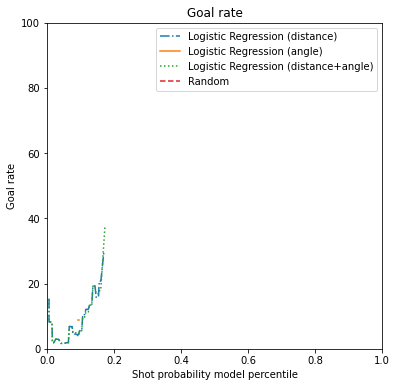

In [54]:
### goal_rate = F(shot probability model percentile) ###
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        r_percentile = round(percentile, 2)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
#             if p<=percentile:
            if round(p, 2)==r_percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals *100 / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates


percentiles1, rates1 = compute_goal_rate_per_percentile(lr_probs1, yp)
percentiles2, rates2 = compute_goal_rate_per_percentile(lr_probs2, yp)
percentiles3, rates3 = compute_goal_rate_per_percentile(lr_probs3, yp)
percentiles4, rates4 = compute_goal_rate_per_percentile(random_probs, yp)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, linestyle='-.', label='Logistic Regression (distance)')
plt.plot(percentiles2, rates2, linestyle='-', label='Logistic Regression (angle)')
plt.plot(percentiles3, rates3, linestyle=':', label='Logistic Regression (distance+angle)')
plt.plot(percentiles4, rates4, linestyle='--', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Goal rate')

plt.savefig('../figures/3-goal_rate_percentile_1.png')

plt.show()

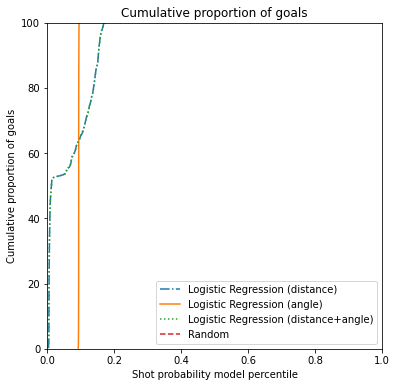

In [56]:
### cumulative portion of goals = F(shot probability model percentile) ###

def compute_cumulative_propotion_of_goals_per_percentile(probs, y):
    percentiles = []
    cum_rates = []
    cum_rate = 0
    total_goals = sum(y)
    cum_goals = 0
    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        cum_goals=0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    cum_goals+=1 
        cum_rate = cum_goals * 100 / total_goals
        percentiles.append(percentile)
        cum_rates.append(cum_rate)
    return percentiles, cum_rates


percentiles1, rates1 = compute_cumulative_propotion_of_goals_per_percentile(lr_probs1, yp)
percentiles2, rates2 = compute_cumulative_propotion_of_goals_per_percentile(lr_probs2, yp)
percentiles3, rates3 = compute_cumulative_propotion_of_goals_per_percentile(lr_probs3, yp)
percentiles4, rates4 = compute_cumulative_propotion_of_goals_per_percentile(random_probs, yp)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, linestyle='-.', label='Logistic Regression (distance)')
plt.plot(percentiles2, rates2, linestyle='-', label='Logistic Regression (angle)')
plt.plot(percentiles3, rates3, linestyle=':', label='Logistic Regression (distance+angle)')
plt.plot(percentiles4, rates4, linestyle='--', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative proportion of goals')
plt.legend(loc='lower right')
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Cumulative proportion of goals')

plt.savefig('../figures/3-goal_rate_percentile_2.png')

plt.show()


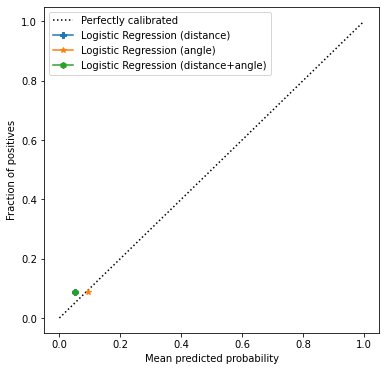

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))


disp1 = CalibrationDisplay.from_estimator(lr_distance, Xp1, yp, label='Logistic Regression (distance)', marker="P", ax=ax)
disp2 = CalibrationDisplay.from_estimator(lr_angle, Xp2, yp, label='Logistic Regression (angle)', marker="*", ax=ax)
disp3 = CalibrationDisplay.from_estimator(lr_distance_angle, Xp3, yp, label='Logistic Regression (distance+angle)', marker="h", ax=ax)

ax.legend(loc='upper left')

plt.savefig('../figures/3-calibration_diagram2.png')

plt.show()